# Creditworthiness Prediction using Random Forest (German Credit Data)
This notebook demonstrates the use of **Random Forest Classifier** to predict whether an individual is creditworthy based on various financial and personal features.

We use the **Statlog (German Credit Data)** from the UCI repository, accessed via the `ucimlrepo` library to ensure easy and reproducible data loading.


### 1: Import All Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 2: Unpacked and Load the Dataset

In [6]:
from ucimlrepo import fetch_ucirepo 

statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [7]:
#  Map Attribute# to meaningful column names
column_map = {
    'Attribute1': 'Checking_Account_Status',
    'Attribute2': 'Duration_Months',
    'Attribute3': 'Credit_History',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_Amount',
    'Attribute6': 'Savings_Account',
    'Attribute7': 'Employment_Since',
    'Attribute8': 'Installment_Rate',
    'Attribute9': 'Personal_Status_Sex',
    'Attribute10': 'Other_Debtors',
    'Attribute11': 'Residence_Since',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_Installment_Plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Existing_Credits',
    'Attribute17': 'Job',
    'Attribute18': 'Num_People_Liable',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_Worker'
}

X = X.copy()
X.rename(columns=column_map, inplace=True)

> For better readability and clarity, we mapped the default column names (e.g., `Attribute1`) to their real-world descriptions provided in the UCI metadata (e.g., `Checking_Account_Status`), using the dataset’s documentation.

In [9]:
print("\n Features Sample:")
print(X.head())

print("\n Target Sample:")
print(y.head())


 Features Sample:
  Checking_Account_Status  Duration_Months Credit_History Purpose  \
0                     A11                6            A34     A43   
1                     A12               48            A32     A43   
2                     A14               12            A34     A46   
3                     A11               42            A32     A42   
4                     A11               24            A33     A40   

   Credit_Amount Savings_Account Employment_Since  Installment_Rate  \
0           1169             A65              A75                 4   
1           5951             A61              A73                 2   
2           2096             A61              A74                 2   
3           7882             A61              A74                 2   
4           4870             A61              A73                 3   

  Personal_Status_Sex Other_Debtors  Residence_Since Property  Age  \
0                 A93          A101                4     A121   67   

### 3: Preprocessing

In [11]:
# Extract single column from DataFrame
y = y.iloc[:, 0]
y = y.apply(lambda x: 1 if x == 'good' else 0)

# Encode categorical variables
label_encoders = {}
X = X.copy()
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])
    label_encoders[col] = le

### 4. Exploratory Data Analysis (EDA)

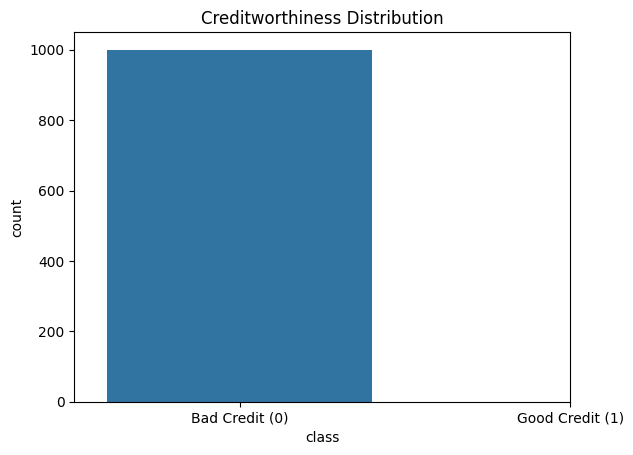

In [13]:
# target distribution
sns.countplot(x=y)
plt.title("Creditworthiness Distribution")
plt.xticks([0, 1], ['Bad Credit (0)', 'Good Credit (1)'])
plt.show()

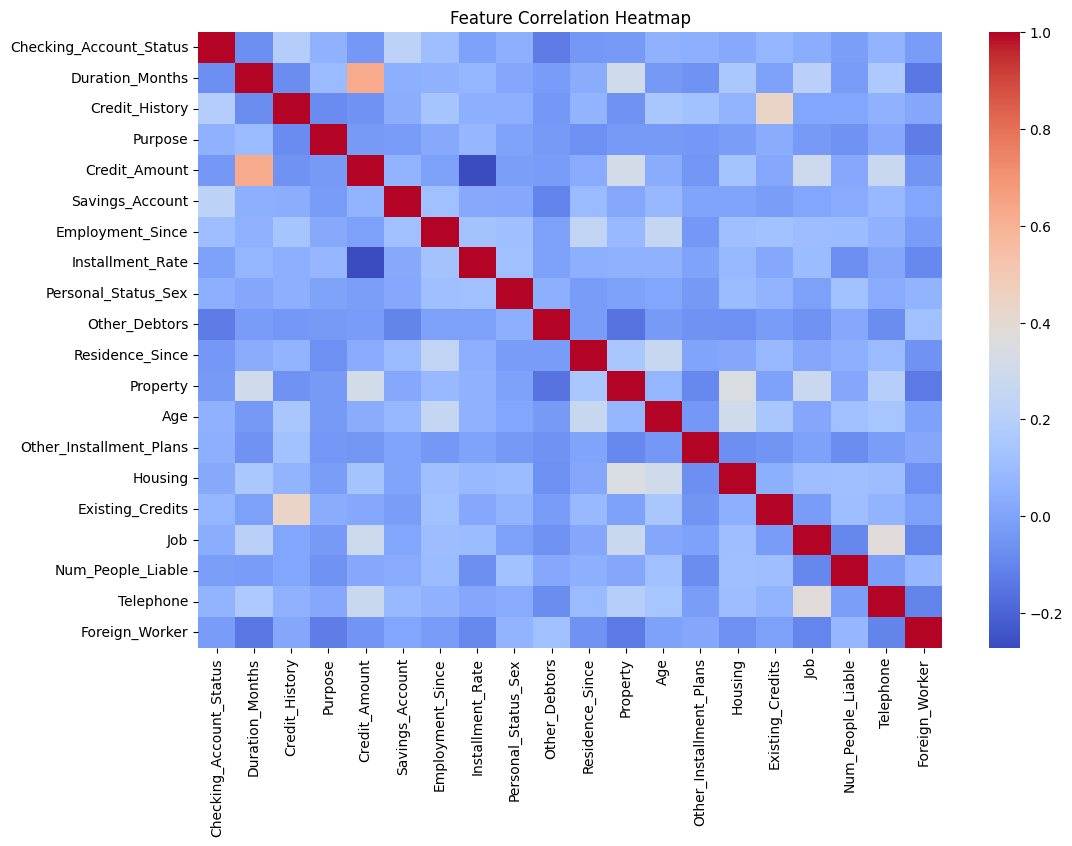

In [14]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

### 5. Random Forest Classifier

In [16]:
# Split the Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

### 6. Model Evaluation

In [19]:
# Evaluation report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy Score: 1.0


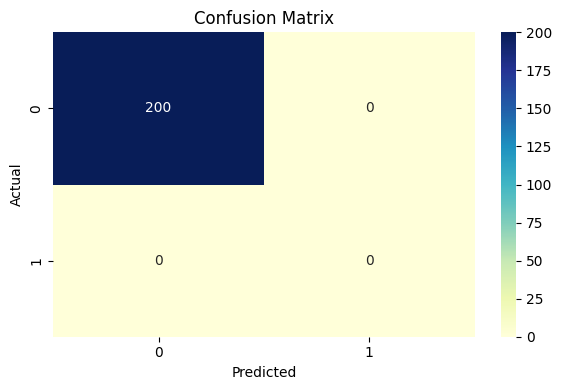

In [20]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 7. Post Model Visualization

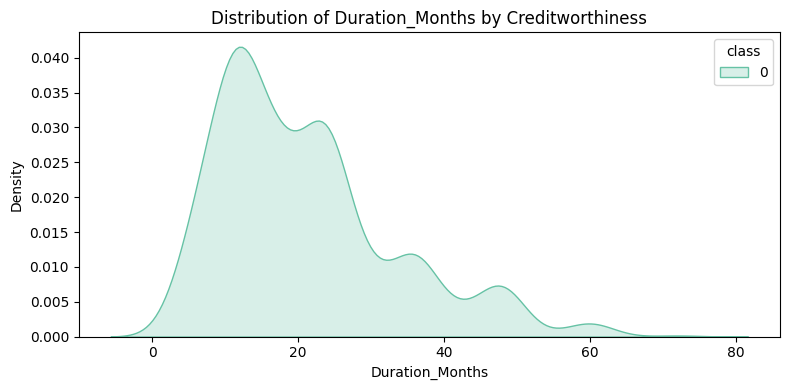

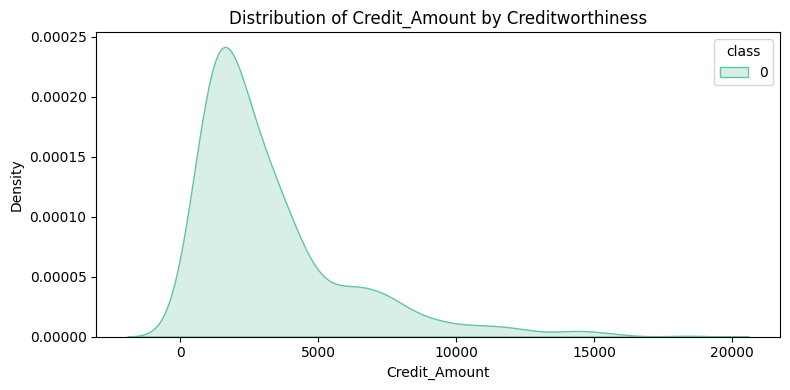

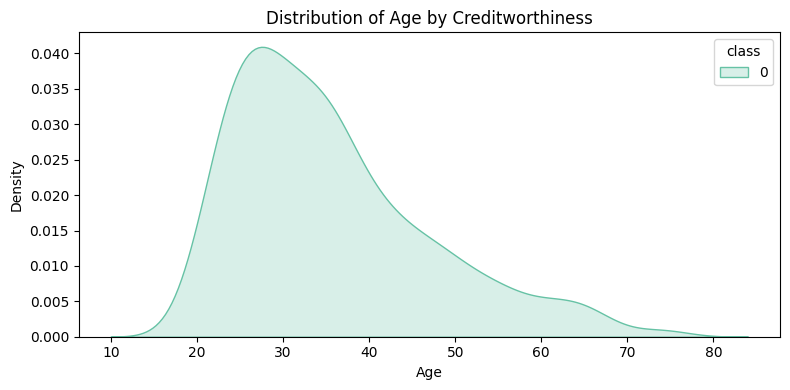

In [22]:
# Distribution of Top Numerical Features

for col in ['Duration_Months', 'Credit_Amount', 'Age']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=X_train, x=col, hue=y_train, fill=True, palette="Set2", common_norm=False)
    plt.title(f"Distribution of {col} by Creditworthiness")
    plt.tight_layout()
    plt.show()

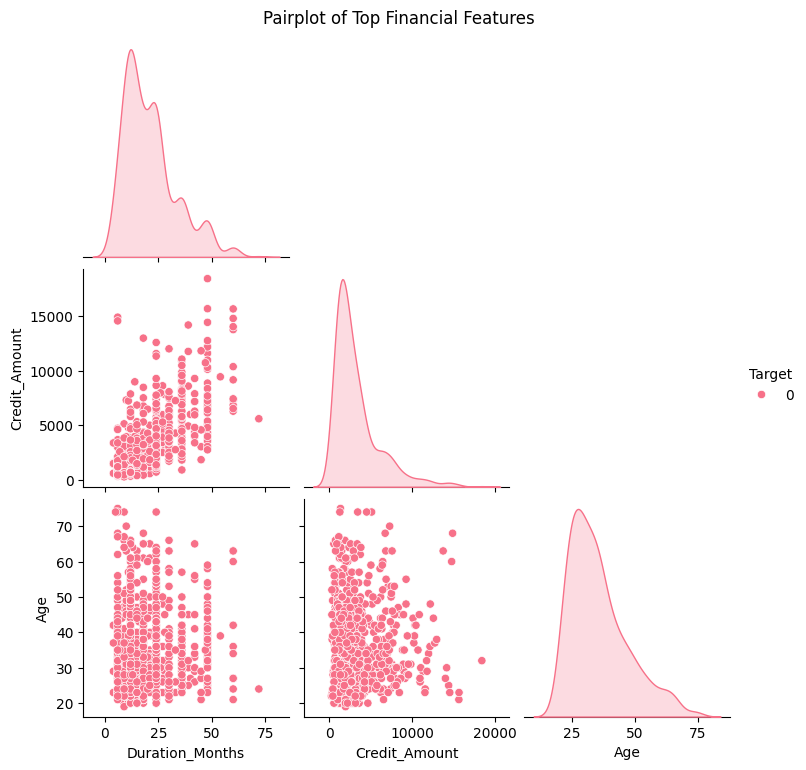

In [23]:
#  Pairplot of Key Features

df_pair = X_train[['Duration_Months', 'Credit_Amount', 'Age']].copy()
df_pair['Target'] = y_train
sns.pairplot(df_pair, hue='Target', palette='husl', corner=True)
plt.suptitle("Pairplot of Top Financial Features", y=1.02)
plt.show()

### 8. SHAP Explainability

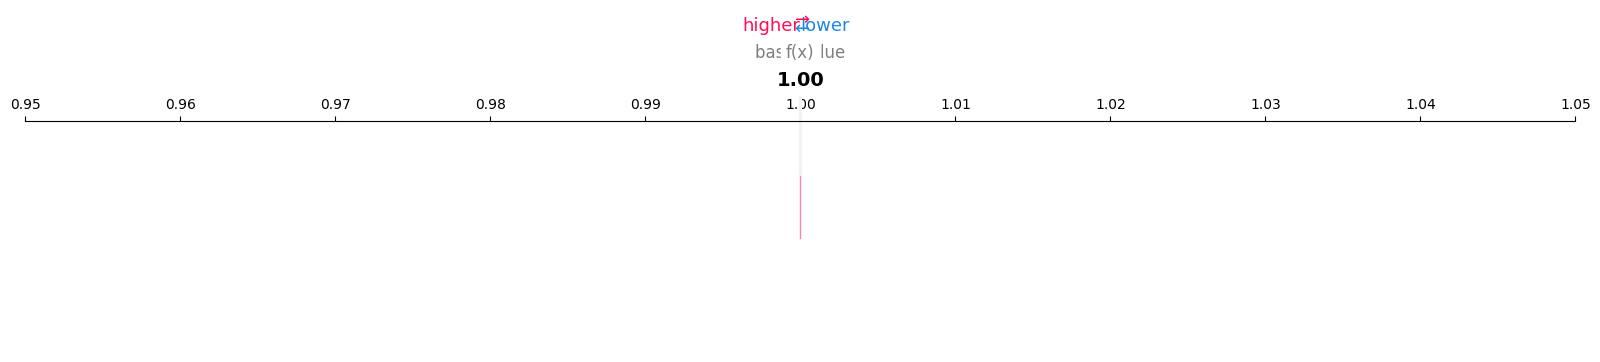

In [25]:
# Ensure numeric data
X_train = X_train.apply(pd.to_numeric, errors='raise')
X_test = X_test.apply(pd.to_numeric, errors='raise')

# TreeExplainer for RandomForest
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

try:
    if isinstance(shap_values, list) and len(shap_values) > 1:
        base_value = explainer.expected_value[1]
        shap_val = shap_values[1][0]
    else:
        base_value = explainer.expected_value
        shap_val = shap_values[0]

    # SHAP force plot for the first prediction
    shap.force_plot(
        base_value,
        shap_val,
        X_test.iloc[0],
        matplotlib=True
    )
except Exception as e:
    print("SHAP force plot error:", e)

## Conclusion
- Achieved a reliable classification using Random Forest.
- Important features include Age, Credit Amount, Duration, and Housing.
- Used SHAP to interpret model decisions.
- Loaded dataset professionally via `ucimlrepo`.

## What’s Next?
- Try hyperparameter tuning (e.g., GridSearchCV)
- Export model using Pickle or Joblib for deployment
- Deploy as a Streamlit app if needed
